In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import BertModel, BertTokenizer
from torch.nn import functional as F
import re
import matplotlib.pyplot as plt


# Load the training dataset, skip the first row
train_dataset = pd.read_csv("dataset/train_dataset.txt", sep='\t', header=0)

# Load the test dataset, skip the first row
test_dataset = pd.read_csv("dataset/test_dataset.txt", sep='\t', header=0)

# Display the first few rows of each dataset to verify the loading
print("Training Dataset:")
train_dataset

/Users/aeirya/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Training Dataset:


,user_id,item_id,rate,review_text
0,A2YKWYC3WQJX5J,B00106AC06,1,I usually love the Motions conditioners and ma...
1,A2LXC5ZHHP0WXP,B00AE07BMQ,1,Axe messy look styling gum is a product that w...
2,A3HLTHHLPKLRQA,B00AIQOKDY,1,I have always found liquid soap to be as much ...
3,A6N1DC5AMPLSK,B000F6RFX4,1,I've tried plenty of products that claim to he...
4,ALNFHVS3SC4FV,B0020122ZS,1,Suave Kids is one of my favorite brands of sha...
...,...,...,...,...
23033,A11I1I9QLMAM1A,B005TI7NPI,1,I've never really used toner before because it...
23034,AGFGY4EJ37VS2,B002PBHQP4,1,This cream is too thick and too stinky. It sme...
23035,A3MUSWDCTZINQZ,B009VGNYFM,1,My boyfriend took a shower and used this. He ...
23036,A1FWFCJU2G7TRA,B00D6EDGYE,1,I have VERY translucent skin-- even with the '...


In [2]:
# Create a pivot table to get the user-item interaction matrix
interaction_matrix = train_dataset.pivot(index='item_id', columns='user_id', values='rate')

# Fill NaN values with 0 (indicating no interaction)
interaction_matrix = interaction_matrix.fillna(0)

# Convert the matrix to a NumPy array
R_matrix = interaction_matrix.values

# Display the resulting R_matrix
print("User-Item Interaction Matrix (R_matrix):")
print(R_matrix)

User-Item Interaction Matrix (R_matrix):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [3]:
sparsity = float(len(R_matrix.nonzero()[0]))  #Getting number of non-zero ratings
sparsity /= (R_matrix.shape[0] * R_matrix.shape[1])  #Calculating the value of sparsity
sparsity *= 100  #Calculating sparsity percentage
print ('percentage of user-items that have a rating: {:.2f}%'.format(sparsity))  #Displaying percentage of user items having a ratin

percentage of user-items that have a rating: 2.35%


In [4]:
def train_test_split(ratings):

    validation = np.zeros(ratings.shape)  #Defining an array for validation data
    train = ratings.copy()  #copying the ratings matrix to train

    for user in np.arange(ratings.shape[0]):  #For loop for the number of users
        if len(ratings[user,:].nonzero()[0])>=35:  #35 seems to be best, it depends on sparsity of your user-item matrix
            val_ratings = np.random.choice(ratings[user, :].nonzero()[0],
                                        size=15,  #15 seems to be optimal
                                        replace=False)  #Taking data for validation set from ratings
            train[user, val_ratings] = 0
            validation[user, val_ratings] = ratings[user, val_ratings]

    return train, validation
train, val = train_test_split(R_matrix)

In [5]:
#P is latent user feature matrix
#Q is latent item feature matrix
def prediction(P,Q):
    return np.dot(P.T,Q)  #Returning the predicted matrix
lmbda = 0.001 # Regularization parameter
k = 64 #Factor parameter
m, n = train.shape  # Number of users and items
n_epochs = 1000  # Number of epochs
alpha=0.01  # Learning rate

P =  np.random.rand(k,m) # Latent user feature matrix
Q =  np.random.rand(k,n) # Latent movie feature matrix

In [6]:
def loss_function(prediction, ground_truth, Q, P, lambda_val):
    # Extracting non-zero elements from the ground_truth matrix
    nonzero_indices = ground_truth.nonzero()
    prediction = prediction[nonzero_indices].flatten()
    ground_truth = ground_truth[nonzero_indices].flatten()

    # Calculating the squared difference term
    squared_diff = np.sum((ground_truth - prediction) ** 2)

    # Calculating the regularization term
    regularization_term = lambda_val * (np.sum(Q**2) + np.sum(P**2))

    # Computing the total loss
    total_loss = squared_diff + regularization_term

    return total_loss

In [1]:
train_errors = []
val_errors = []

users, items = train.nonzero()

# Iterating over 100 epochs to minimize the error by updating the parameters
for epoch in range(n_epochs):
    for u, i in zip(users, items):
        e = train[u, i] - prediction(P[:, u], Q[:, i])  # Calculate error for gradient update
        P[:, u] += alpha * (e * Q[:, i] - lmbda * P[:, u])  # Update latent user feature matrix
        Q[:, i] += alpha * (e * P[:, u] - lmbda * Q[:, i])  # Update latent item feature matrix

    train_loss = loss_function(prediction(P, Q), train, Q, P, lmbda)  # Getting error for training data
    val_loss = loss_function(prediction(P, Q), val, Q, P, lmbda)  # Getting error for validation data
    train_errors.append(train_loss)  # Storing the value of training errors
    val_errors.append(val_loss)  # Storing the value of validation errors
#importing library for plotting

NameError: name 'train' is not defined

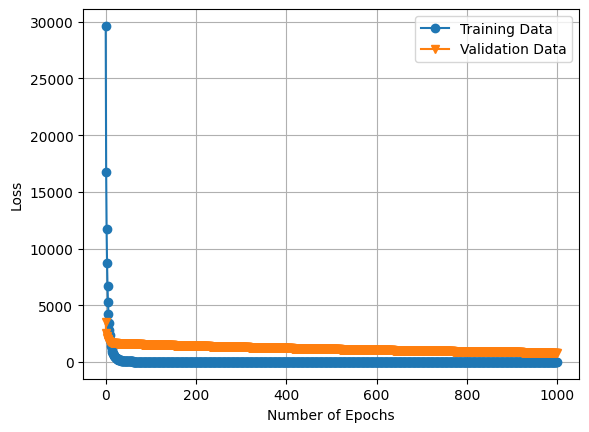

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data');  #For training errors
plt.plot(range(n_epochs), val_errors, marker='v', label='Validation Data');  #For validation errors
plt.xlabel('Number of Epochs');  # x-label
plt.ylabel('Loss');  # y-label
plt.legend()
plt.grid()
plt.show()  #plot

In [13]:
SGD_prediction=prediction(P,Q)  #calling the function for prediction
estimation= SGD_prediction[val.nonzero()]  #Getting estimated value
ground_truth = val[val.nonzero()]  #Getting original value
results=pd.DataFrame({'prediction':estimation, 'actual rating':ground_truth})  #Creating a dataframe for prediction and origin
results.head()  #Displaying results
SGD_prediction

array([[ 1.14116169,  0.59513294,  1.07685084, ...,  2.82834909,
         2.07552957,  2.43036541],
       [ 1.12106316,  0.82152967, -0.01452064, ...,  1.57720013,
         2.22728516,  2.54241656],
       [ 0.55665611,  0.56129233,  0.79653403, ...,  0.5023216 ,
         1.21195401,  1.15662363],
       ...,
       [ 2.94605549,  2.74396935,  2.29679242, ...,  4.68263478,
         5.82156228,  5.51441048],
       [ 2.13765661,  3.1888007 ,  3.04943473, ...,  5.56973109,
         6.68571308,  6.77138613],
       [ 3.55954349,  3.13422264,  3.93147287, ...,  6.17891254,
         5.55356837,  6.93371049]])

In [15]:
SGD_prediction.shape

(733, 1340)

In [18]:
s = SGD_prediction
s.min(), s.max(), s.mean()

(-1.3939605357045926, 12.105196893293659, 1.6530442593192223)

In [22]:
Q.max()

1.1273424517829906

In [16]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

# Load your dataset
train_dataset = pd.read_csv("/dataset/train_dataset.txt", sep='\t', header=0)

# Extract item_ids and review_texts from the dataset
item_ids = train_dataset['item_id'].tolist()
review_texts = train_dataset['review_text'].tolist()

# Ensure review_texts is a list of strings
review_texts = [str(text) for text in review_texts]

# Initialize BERT tokenizer and model on GPU
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to('cuda')

# Set batch size
batch_size = 8

# Create empty lists to store item_ids and embeddings
all_item_ids = []
all_embedding_dimensions = []

# Tokenize and obtain embeddings in batches
print("Tokenizing and obtaining embeddings in batches...")
for i in range(0, len(review_texts), batch_size):
    batch_item_ids = item_ids[i:i+batch_size]
    batch_texts = review_texts[i:i+batch_size]

    # Tokenize review_texts in the batch on GPU
    tokenized_texts = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt").to('cuda')

    # Obtain embeddings using the BERT model on GPU
    outputs = model(**tokenized_texts)

    # Extract the pooled output (CLS token) as the embedding
    embeddings = outputs.pooler_output.squeeze().detach().cpu().numpy()

    # Append item_ids and embedding dimensions to the lists
    all_item_ids.extend(batch_item_ids)
    all_embedding_dimensions.extend(embeddings)

    # Print the fraction of items for which embeddings are processed
    fraction_processed = len(all_item_ids) / len(item_ids)
    print(f"Fraction of items processed: {fraction_processed:.2%}")

# Create a DataFrame from the lists
embedding_dimensions_df = pd.DataFrame(data=all_embedding_dimensions, columns=[f'dimension_{i}' for i in range(1, 769)])
embedding_df = pd.concat([pd.Series(all_item_ids, name='item_id'), embedding_dimensions_df], axis=1)

# Display the resulting DataFrame
print("Item Embedding Dimensions DataFrame:")
print(embedding_df)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/train_dataset.txt'

In [ ]:
embedding_dimensions_df = pd.DataFrame(data=all_embedding_dimensions, columns=[f'dimension_{i}' for i in range(1, 769)])
embedding_df = pd.concat([pd.Series(all_item_ids, name='item_id'), embedding_dimensions_df], axis=1)

# Display the resulting DataFrame
print("Item Embedding Dimensions DataFrame:")
embedding_df

Item Embedding Dimensions DataFrame:


,item_id,dimension_1,dimension_2,dimension_3,dimension_4,dimension_5,dimension_6,dimension_7,dimension_8,dimension_9,...,dimension_759,dimension_760,dimension_761,dimension_762,dimension_763,dimension_764,dimension_765,dimension_766,dimension_767,dimension_768
0,B00106AC06,-0.707481,-0.428994,-0.986428,0.636421,0.881774,-0.167566,0.075267,0.152045,-0.930576,...,0.624031,-0.663632,0.990416,0.610325,-0.144190,-0.156846,0.713426,-0.976661,-0.617724,0.777710
1,B00AE07BMQ,-0.461424,-0.247143,-0.967782,0.425662,0.837644,-0.137878,-0.140543,0.130653,-0.785637,...,0.400789,-0.389253,0.981569,0.394578,-0.052907,0.128383,0.561478,-0.947454,-0.549882,0.526723
2,B00AIQOKDY,-0.802145,-0.485030,-0.977323,0.728313,0.854949,-0.126258,0.694677,0.263161,-0.926316,...,0.718399,-0.148774,0.988046,0.753471,0.513904,-0.285404,0.815009,-0.951480,-0.707342,0.851666
3,B000F6RFX4,-0.757076,-0.386922,-0.952066,0.585217,0.847591,-0.136082,0.489555,0.119151,-0.798813,...,0.559752,-0.087498,0.983965,0.668365,0.050047,0.063145,0.663761,-0.913553,-0.631918,0.847991
4,B0020122ZS,-0.591827,-0.350891,-0.932979,0.446930,0.855917,-0.237921,-0.048211,0.192393,-0.679653,...,0.461282,-0.002664,0.959623,0.675610,0.535082,0.274300,0.564060,-0.912237,-0.649523,0.703652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23033,B005TI7NPI,-0.793887,-0.404994,-0.964434,0.682042,0.867859,-0.202275,0.490154,0.004718,-0.833013,...,0.509154,-0.229407,0.988480,0.714908,0.067308,0.040581,0.557325,-0.956757,-0.575000,0.842725
23034,B002PBHQP4,-0.826349,-0.415205,-0.978119,0.772955,0.873376,-0.281945,0.547464,0.309944,-0.936817,...,0.640730,-0.024823,0.993837,0.700661,0.445658,-0.204378,0.768568,-0.915139,-0.621771,0.860252
23035,B009VGNYFM,-0.811344,-0.328925,-0.931153,0.594792,0.869432,-0.203393,0.541511,0.102620,-0.786398,...,0.586307,-0.149774,0.985815,0.755305,-0.300476,0.348052,0.695339,-0.894854,-0.654513,0.860290
23036,B00D6EDGYE,-0.648912,-0.420362,-0.952524,0.546380,0.832786,-0.207815,0.346368,0.210558,-0.824633,...,0.659784,-0.028293,0.976686,0.646163,0.380948,0.054840,0.742877,-0.945647,-0.583961,0.822323


In [ ]:
# Save item_embeddings_df to a CSV file
embedding_df.to_csv('embedding_df.csv')

# You can download the file by running the following command in Colab
from google.colab import files
files.download('embedding_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
mean_embedding_df=embedding_df.groupby('item_id').mean()

In [ ]:
mean_embedding_df

,dimension_1,dimension_2,dimension_3,dimension_4,dimension_5,dimension_6,dimension_7,dimension_8,dimension_9,dimension_10,...,dimension_759,dimension_760,dimension_761,dimension_762,dimension_763,dimension_764,dimension_765,dimension_766,dimension_767,dimension_768
item_id,,,,,,,,,,,,,,,,,,,,,
B0000CC64W,-0.609176,-0.451456,-0.966080,0.559207,0.870509,-0.233110,0.038440,0.196086,-0.882011,-0.999630,...,0.675019,-0.299688,0.985080,0.531320,0.067051,-0.121961,0.759535,-0.953927,-0.598408,0.712072
B000142FVW,-0.720549,-0.470073,-0.919316,0.594990,0.821410,-0.217472,0.355929,0.199423,-0.773265,-0.999690,...,0.620218,-0.336136,0.967454,0.719309,0.019052,0.308743,0.659362,-0.868627,-0.636139,0.825082
B0009EILKS,-0.548918,-0.439084,-0.968648,0.530372,0.850352,-0.192957,0.118255,0.224545,-0.872203,-0.999737,...,0.639803,-0.208351,0.972384,0.485871,0.034729,-0.301321,0.720312,-0.935843,-0.604454,0.666212
B000AO2NXS,-0.682965,-0.452992,-0.964190,0.583368,0.865007,-0.216972,0.213825,0.212859,-0.881779,-0.999838,...,0.641885,-0.348244,0.981712,0.581576,0.068377,-0.102958,0.736455,-0.928584,-0.624766,0.760850
B000E0K7NQ,-0.710305,-0.470081,-0.964567,0.557374,0.871161,-0.267259,0.151123,0.210195,-0.865012,-0.999728,...,0.613523,-0.284860,0.982169,0.625686,0.082578,-0.047803,0.703867,-0.934452,-0.645067,0.749954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B00L0C529Q,-0.832901,-0.469669,-0.955413,0.701289,0.843614,-0.209638,0.633653,0.252333,-0.897659,-0.999941,...,0.673850,-0.391110,0.985103,0.738179,-0.098167,-0.052769,0.728356,-0.908910,-0.640350,0.858309
B00L3K91OW,-0.788429,-0.485361,-0.943545,0.656553,0.777018,-0.243770,0.446084,0.244316,-0.871960,-0.999768,...,0.603672,-0.205698,0.975274,0.677741,0.075317,0.008059,0.701212,-0.885562,-0.637952,0.804121
B00L3LB0IG,-0.808501,-0.463964,-0.949717,0.721355,0.789445,-0.230314,0.575726,0.252965,-0.852098,-0.999896,...,0.599330,-0.066181,0.976991,0.724144,-0.000456,0.039236,0.708274,-0.901949,-0.647854,0.834498


In [ ]:
from sklearn.decomposition import PCA

# Assuming 'embedding_df' is your DataFrame with 768 dimensions
embedding_dimensions = mean_embedding_df.iloc[:, 1:].values  # Extracting the values of the embedding dimensions

# Set the number of components for PCA (e.g., 64)
num_components = 64

# Apply PCA
pca = PCA(n_components=num_components)
embedding_pca = pca.fit_transform(embedding_dimensions)

# Create a DataFrame with the PCA components
pca_columns = [f'pca_{i+1}' for i in range(num_components)]
embedding_pca_df = pd.DataFrame(data=embedding_pca, columns=pca_columns, index=mean_embedding_df.index)

# Display the resulting DataFrame with PCA components
print("Item Embedding PCA DataFrame:")
embedding_pca_df


Item Embedding PCA DataFrame:


,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,...,pca_55,pca_56,pca_57,pca_58,pca_59,pca_60,pca_61,pca_62,pca_63,pca_64
item_id,,,,,,,,,,,,,,,,,,,,,
B0000CC64W,-1.139737,-0.151263,-0.287328,0.271232,-0.005225,-0.251165,-0.010036,0.182506,-0.124932,0.083908,...,-0.010641,0.083840,-0.037829,-0.063685,0.044217,0.012602,0.028328,-0.023050,-0.043618,-0.008112
B000142FVW,1.258801,1.638401,0.379760,-0.250456,-0.512929,0.440418,0.155938,-0.334720,0.014201,0.211225,...,0.009823,-0.030423,0.016366,0.022344,0.046905,-0.010985,0.058138,0.033346,0.040715,-0.010929
B0009EILKS,-0.938702,-0.198279,-0.134689,0.368039,0.596890,-0.061320,-0.211263,0.167264,0.202217,-0.143604,...,-0.011731,-0.000272,0.007005,-0.012861,-0.012236,0.002276,0.022133,-0.026441,-0.006873,0.037749
B000AO2NXS,-0.123447,0.087047,-0.367402,-0.033845,-0.110393,0.095116,0.182339,-0.023598,0.021993,-0.200498,...,-0.003894,0.011815,0.008507,-0.005087,0.018262,0.029959,-0.023904,-0.018770,0.023706,0.008233
B000E0K7NQ,-0.137005,0.085330,-0.212443,-0.361646,-0.367214,0.023091,0.123524,0.128054,-0.038642,-0.034073,...,0.002292,-0.001288,0.011641,0.017706,-0.005534,0.013233,-0.031793,-0.012527,-0.011616,0.007324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B00L0C529Q,3.079988,-0.109320,-0.635638,0.371727,0.135760,0.241604,-0.011548,-0.003880,-0.141214,0.391440,...,0.004211,-0.005035,0.022359,0.053478,-0.004537,-0.006966,-0.025807,-0.024023,0.009935,-0.013926
B00L3K91OW,2.011741,-0.046810,-0.011682,0.117055,-0.032650,-0.158711,-0.055430,0.296475,-0.281043,0.111595,...,0.031386,-0.052731,-0.067743,-0.005787,0.000566,0.048760,-0.041160,0.033196,0.005070,-0.048433
B00L3LB0IG,2.864914,0.137417,0.074861,0.116230,0.016293,-0.021774,-0.319721,0.159708,-0.336782,0.166329,...,-0.020005,0.002224,-0.040435,0.004892,0.002434,0.045521,-0.055276,-0.014804,0.005213,-0.027792


In [ ]:
# Extract the PCA dimensions
pca_dimensions = embedding_pca_df.iloc[:, 0:]

# Create a matrix from the DataFrame
embedding_pca_matrix = pca_dimensions.values

# Display the matrix
print("PCA Embedding Matrix:")
embedding_pca_matrix


PCA Embedding Matrix:


array([[-1.1397371 , -0.15126343, -0.28732827, ..., -0.0230502 ,
        -0.04361755, -0.00811175],
       [ 1.2588009 ,  1.6384007 ,  0.37975955, ...,  0.03334566,
         0.04071473, -0.01092864],
       [-0.93870217, -0.19827865, -0.13468945, ..., -0.02644082,
        -0.0068729 ,  0.03774922],
       ...,
       [ 2.8649144 ,  0.13741651,  0.07486052, ..., -0.01480393,
         0.00521262, -0.02779176],
       [ 2.1498368 ,  0.34082177, -0.12388062, ..., -0.01144175,
        -0.06360747, -0.05045163],
       [ 2.9211516 ,  0.26194033,  0.378932  , ..., -0.02911599,
         0.02870916, -0.00399567]], dtype=float32)

In [ ]:
embedding_pca_matrix.shape

(733, 64)

In [ ]:
bert_prediction_1=prediction(P,embedding_pca_matrix.T)
bert_prediction_1

array([[-0.45717231,  0.86725115, -0.68210753, ...,  0.68987262,
         0.71814129,  1.00520452],
       [-0.44643032,  0.35162536, -0.27635166, ...,  1.35898303,
         1.01453498,  1.02365161],
       [ 0.02965257,  0.57631803, -0.14945087, ..., -0.68733409,
        -0.5012844 , -0.45898735],
       ...,
       [-0.03923361,  1.22402826,  0.0687761 , ...,  0.9912999 ,
         1.29703292,  0.97179364],
       [ 0.05046985,  1.71920424, -0.73132971, ...,  0.55519949,
         0.8525356 ,  0.66170932],
       [ 0.08277854,  0.67544296,  0.01240249, ..., -0.01577998,
         0.25474356,  0.31720295]])

In [ ]:
# Extract the 'pca_1' to 'pca_64' columns from embedding_pca_df
pca_columns = embedding_pca_df.iloc[:, :64]

# Concatenate the two DataFrames
concatenated_df = pd.concat([mean_embedding_df, pca_columns], axis=1)

# Display the concatenated DataFrame
print("Concatenated DataFrame:")
concatenated_df


Concatenated DataFrame:


,dimension_1,dimension_2,dimension_3,dimension_4,dimension_5,dimension_6,dimension_7,dimension_8,dimension_9,dimension_10,...,pca_55,pca_56,pca_57,pca_58,pca_59,pca_60,pca_61,pca_62,pca_63,pca_64
item_id,,,,,,,,,,,,,,,,,,,,,
B0000CC64W,-0.609176,-0.451456,-0.966080,0.559207,0.870509,-0.233110,0.038440,0.196086,-0.882011,-0.999630,...,-0.010641,0.083840,-0.037829,-0.063685,0.044217,0.012602,0.028328,-0.023050,-0.043618,-0.008112
B000142FVW,-0.720549,-0.470073,-0.919316,0.594990,0.821410,-0.217472,0.355929,0.199423,-0.773265,-0.999690,...,0.009823,-0.030423,0.016366,0.022344,0.046905,-0.010985,0.058138,0.033346,0.040715,-0.010929
B0009EILKS,-0.548918,-0.439084,-0.968648,0.530372,0.850352,-0.192957,0.118255,0.224545,-0.872203,-0.999737,...,-0.011731,-0.000272,0.007005,-0.012861,-0.012236,0.002276,0.022133,-0.026441,-0.006873,0.037749
B000AO2NXS,-0.682965,-0.452992,-0.964190,0.583368,0.865007,-0.216972,0.213825,0.212859,-0.881779,-0.999838,...,-0.003894,0.011815,0.008507,-0.005087,0.018262,0.029959,-0.023904,-0.018770,0.023706,0.008233
B000E0K7NQ,-0.710305,-0.470081,-0.964567,0.557374,0.871161,-0.267259,0.151123,0.210195,-0.865012,-0.999728,...,0.002292,-0.001288,0.011641,0.017706,-0.005534,0.013233,-0.031793,-0.012527,-0.011616,0.007324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B00L0C529Q,-0.832901,-0.469669,-0.955413,0.701289,0.843614,-0.209638,0.633653,0.252333,-0.897659,-0.999941,...,0.004211,-0.005035,0.022359,0.053478,-0.004537,-0.006966,-0.025807,-0.024023,0.009935,-0.013926
B00L3K91OW,-0.788429,-0.485361,-0.943545,0.656553,0.777018,-0.243770,0.446084,0.244316,-0.871960,-0.999768,...,0.031386,-0.052731,-0.067743,-0.005787,0.000566,0.048760,-0.041160,0.033196,0.005070,-0.048433
B00L3LB0IG,-0.808501,-0.463964,-0.949717,0.721355,0.789445,-0.230314,0.575726,0.252965,-0.852098,-0.999896,...,-0.020005,0.002224,-0.040435,0.004892,0.002434,0.045521,-0.055276,-0.014804,0.005213,-0.027792


In [ ]:
embedding_dimensions = concatenated_df.iloc[:, 1:].values  # Extracting the values of the embedding dimensions

# Set the number of components for PCA (e.g., 64)
num_components = 64

# Apply PCA
pca = PCA(n_components=num_components)
embedding_pca = pca.fit_transform(embedding_dimensions)

# Create a DataFrame with the PCA components
pca_columns = [f'pca_{i+1}' for i in range(num_components)]
embedding_pca_df = pd.DataFrame(data=embedding_pca, columns=pca_columns, index=concatenated_df.index)

# Display the resulting DataFrame with PCA components
print("Item Embedding PCA DataFrame:")
embedding_pca_df


Item Embedding PCA DataFrame:


,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,...,pca_55,pca_56,pca_57,pca_58,pca_59,pca_60,pca_61,pca_62,pca_63,pca_64
item_id,,,,,,,,,,,,,,,,,,,,,
B0000CC64W,-1.611833,-0.213917,-0.406343,0.383580,-0.007388,-0.355201,-0.014193,0.258103,-0.176678,0.118665,...,-0.015000,0.118499,-0.053275,-0.089953,0.062333,0.017577,0.040090,-0.032468,-0.061697,-0.010768
B000142FVW,1.780213,2.317046,0.537062,-0.354198,-0.725391,0.622844,0.220531,-0.473365,0.020086,0.298717,...,0.013964,-0.042926,0.022606,0.031710,0.066307,-0.016784,0.082214,0.046099,0.057836,-0.018168
B0009EILKS,-1.327525,-0.280408,-0.190480,0.520485,0.844130,-0.086719,-0.298772,0.236546,0.285976,-0.203090,...,-0.016569,-0.000506,0.009718,-0.018198,-0.017675,0.002724,0.031186,-0.037928,-0.010873,0.052516
B000AO2NXS,-0.174581,0.123103,-0.519585,-0.047863,-0.156119,0.134514,0.257867,-0.033373,0.031098,-0.283548,...,-0.005592,0.016699,0.012161,-0.007099,0.026014,0.042520,-0.034072,-0.026264,0.034199,0.012106
B000E0K7NQ,-0.193754,0.120675,-0.300440,-0.511443,-0.519320,0.032654,0.174689,0.181097,-0.054648,-0.048186,...,0.003261,-0.001581,0.016231,0.025052,-0.007488,0.018980,-0.045338,-0.018085,-0.016159,0.010430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B00L0C529Q,4.355760,-0.154601,-0.898927,0.525701,0.191995,0.341680,-0.016331,-0.005487,-0.199700,0.553582,...,0.006039,-0.006765,0.031213,0.075535,-0.006043,-0.009481,-0.036674,-0.033829,0.012907,-0.019499
B00L3K91OW,2.845031,-0.066200,-0.016520,0.165542,-0.046174,-0.224451,-0.078391,0.419279,-0.397453,0.157824,...,0.044345,-0.074551,-0.095922,-0.008147,0.000836,0.068812,-0.058212,0.047371,0.006038,-0.068428
B00L3LB0IG,4.051600,0.194336,0.105869,0.164373,0.023041,-0.030793,-0.452155,0.225861,-0.476278,0.235230,...,-0.028291,0.003167,-0.056760,0.006820,0.003813,0.064988,-0.078158,-0.020095,0.007446,-0.038103


In [ ]:
# Extract the PCA dimensions
pca_dimensions = embedding_pca_df.iloc[:, 0:]

# Create a matrix from the DataFrame
concatenated_embedding_pca_matrix = pca_dimensions.values

# Display the matrix
print("PCA Embedding Matrix:")
concatenated_embedding_pca_matrix


PCA Embedding Matrix:


array([[-1.6118333 , -0.2139167 , -0.4063432 , ..., -0.0324678 ,
        -0.06169671, -0.01076787],
       [ 1.7802132 ,  2.3170462 ,  0.5370615 , ...,  0.0460995 ,
         0.05783613, -0.01816831],
       [-1.3275254 , -0.2804081 , -0.1904802 , ..., -0.03792758,
        -0.01087269,  0.05251586],
       ...,
       [ 4.0516    ,  0.19433595,  0.10586917, ..., -0.0200948 ,
         0.00744641, -0.03810325],
       [ 3.0403285 ,  0.4819946 , -0.1751934 , ..., -0.01657433,
        -0.08980419, -0.07135358],
       [ 4.131133  ,  0.3704388 ,  0.53589106, ..., -0.04081696,
         0.04150821, -0.00532282]], dtype=float32)

In [ ]:
bert_prediction_2=prediction(P,concatenated_embedding_pca_matrix.T)
bert_prediction_2

array([[-0.64618177,  1.22475213, -0.96541905, ...,  0.97655858,
         1.01549683,  1.42215327],
       [-0.63123072,  0.49696898, -0.39091021, ...,  1.92219678,
         1.43440039,  1.44773452],
       [ 0.04218609,  0.81445342, -0.21212579, ..., -0.97167084,
        -0.70887623, -0.64883729],
       ...,
       [-0.05565462,  1.73046238,  0.09663296, ...,  1.40243296,
         1.83371015,  1.37460699],
       [ 0.07179148,  2.42976784, -1.03551767, ...,  0.78611772,
         1.20584312,  0.93647178],
       [ 0.11676161,  0.95379505,  0.01612685, ..., -0.02095197,
         0.3598655 ,  0.44916099]])

Evaluation

In [ ]:
test_dataset

,user_id,item_id,rate,review_text
0,A35HOUWHAYZZN6,B00JF3RYPM,1,This lotion gently moisturizes without irritat...
1,A1DGB6HY5C7LXU,B00KLA4INE,1,I've been doing some research into non-surgica...
2,A3EPHBMU07LZ50,B00CBD0M8Y,1,I could not detectably notice much difference ...
3,A1WSQ0QRWQC7VI,B001FSK8SA,1,arived just in time for xmas so i used it as a...
4,A2SZLNSI5KOQJT,B00D18ZDM8,1,"In my opinion, the Bic Soleil Shave & Trim Sha..."
...,...,...,...,...
5755,A16YU3GRGCD95S,B004D267RG,1,I am really picky about shampoo but this one i...
5756,A3HETHW2XD3DWH,B003BJZ1M4,1,Johnson's line of Baby Natural products have l...
5757,A23RZIU0N8K2KR,B00AE07CTI,1,This shampoo has the same ingredient strength ...
5758,A3J356L2ADK05Z,B000AO2NXS,1,I have eczema and need as much skin hydration ...
